# Application: Creating a Telco Mobility Index

1. Total Travel Distance
2. Radius of Gyration
3. Activity Entropy

In [1]:
import os
os.chdir("../") # cd back to the root folder

In [2]:
import warnings
warnings.filterwarnings("ignore")

import random
import shapely
import pendulum
import numpy as np
import pandas as pd
pd.options.display.max_rows=200
import geopandas as gpd
import matplotlib.pyplot as plt
from sds4gdsp.processor import convert_cel_to_point, calc_haversine_distance
from sds4gdsp.plotter import get_route_fig, load_images, plot_images
from IPython.display import HTML, display
from functools import reduce
import pyproj
from functools import partial

Please load, take a peek, and examine the given datasets

### Fake Subscribers

The subscriber base, **by default**, should have:
- 100 unique subs
- At least 18 years old
- At most 72 years old

In [3]:
filepath_subscribers = "data/fake_subscribers.csv"
dtype = dict(
    gender="category",
    age=int,
    name=str,
    chi_indicator=bool,
    ewallet_user_indicator="category"
)
fake_subscribers = pd.read_csv(filepath_subscribers, dtype=dtype)
fake_subscribers.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator
20,glo-sub-021,male,62,Eric Hall,False,Y
113,glo-sub-114,male,47,Derek Davis,True,Y
24,glo-sub-025,male,49,Kyle Garcia,True,N
42,glo-sub-043,female,61,Lori Watson,False,Y
102,glo-sub-103,female,20,Teresa Kramer,True,Y


In [4]:
fake_subscribers.shape

(200, 6)

In [5]:
cat_cols = ["gender", "chi_indicator", "ewallet_user_indicator"]
fs_breakdown = fake_subscribers.groupby(cat_cols).size().reset_index(name="cnt")
fs_breakdown.assign(pcnt=fs_breakdown.cnt.div(len(fake_subscribers)).mul(100).round(2))

,gender,chi_indicator,ewallet_user_indicator,cnt,pcnt
0,female,False,N,27,13.5
1,female,False,Y,24,12.0
2,female,True,N,23,11.5
3,female,True,Y,33,16.5
4,male,False,N,22,11.0
5,male,False,Y,29,14.5
6,male,True,N,25,12.5
7,male,True,Y,17,8.5


### Fake Cellsites

The cellsites, **by default**, should:
- be situated in Taguig City, Metro Manila, PH
- have cellsites that are at least 300 meters apart

In [6]:
filepath_cellsites = "data/fake_cellsites.csv"
fake_cellsites = pd.read_csv(filepath_cellsites)
fake_cellsites.sample(5)

,cel_uid,coords
31,glo-cel-032,POINT (121.0499415 14.5159856)
43,glo-cel-044,POINT (121.0550896 14.5056935)
11,glo-cel-012,POINT (121.0395857 14.5055214)
47,glo-cel-048,POINT (121.0565103 14.4833339)
59,glo-cel-060,POINT (121.060757 14.4782484)


In [7]:
fake_cellsites.shape

(111, 2)

In [8]:
HTML('<img src="../docs/fake_cellsites.png" width="600" height="600"/>')

### Fake Transactions

The transactions, **by default**, should:
- start the earliest at around 7:00 AM
- cover the whole month of July 2023
- have intra-Taguig transactions only

In [9]:
filepath_transactions = "data/fake_transactions.csv"
fake_transactions = pd.read_csv(filepath_transactions)

In [10]:
fake_transactions.shape

(65766, 5)

In [11]:
min_date = pendulum.parse(fake_transactions.transaction_dt.min(), exact=True)
max_date = pendulum.parse(fake_transactions.transaction_dt.max(), exact=True)
period = pendulum.period(min_date, max_date)

In [12]:
sample_dt = str(random.sample(list(period), 1)[0])
filter_dt = fake_transactions.transaction_dt == sample_dt
sample_sub = fake_subscribers.sub_uid.sample(1).item()
filter_sub = fake_transactions.sub_uid == sample_sub
fake_transactions.loc[filter_sub&filter_dt]

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr
42245,glo-txn-42246,glo-sub-049,glo-cel-088,2023-06-14,4
42246,glo-txn-42247,glo-sub-049,glo-cel-090,2023-06-14,6
42247,glo-txn-42248,glo-sub-049,glo-cel-088,2023-06-14,7
42248,glo-txn-42249,glo-sub-049,glo-cel-094,2023-06-14,9
42249,glo-txn-42250,glo-sub-049,glo-cel-088,2023-06-14,11
42250,glo-txn-42251,glo-sub-049,glo-cel-094,2023-06-14,15
42251,glo-txn-42252,glo-sub-049,glo-cel-088,2023-06-14,16
42252,glo-txn-42253,glo-sub-049,glo-cel-094,2023-06-14,17
42253,glo-txn-42254,glo-sub-049,glo-cel-097,2023-06-14,18
42254,glo-txn-42255,glo-sub-049,glo-cel-104,2023-06-14,22


Create a helper function to help fetch subscriber trajectory

In [13]:
def get_sub_traj(
    sub: str,
    date: str,
    window: str,
    transactions: pd.DataFrame,
    cellsites: pd.DataFrame
):
    if window=="month":
        date_filter = transactions.transaction_dt.apply(lambda d: pendulum.parse(d, exact=True).start_of("month").to_date_string())==date
    elif window=="day":
        date_filter = transactions.transaction_dt==date
    sub_filter = transactions.sub_uid==sub
    transactions_red = transactions.loc[sub_filter&date_filter]
    transactions_red = transactions_red.merge(cellsites, on="cel_uid")
    return transactions_red.sort_values(by=["transaction_dt", "transaction_hr"], ascending=[1, 1]).reset_index(drop=True)

def fetch_sample_trajs(scoring_base, metric, date, window, fake_transactions, fake_cellsites):
    scoring_base.sort_values(by=metric, ascending=True, inplace=True)
    scoring_base.reset_index(drop=True, inplace=True)
    sample_sub_low = scoring_base.loc[0, "sub_uid"]
    sample_sub_mid = scoring_base.loc[len(scoring_base)//2, "sub_uid"]
    sample_sub_high = scoring_base.loc[len(scoring_base)-1, "sub_uid"]
    sample_traj_low = get_sub_traj(sample_sub_low, date, window, fake_transactions, fake_cellsites)
    sample_traj_mid = get_sub_traj(sample_sub_mid, date, window, fake_transactions, fake_cellsites)
    sample_traj_high = get_sub_traj(sample_sub_high, date, window, fake_transactions, fake_cellsites)
    return sample_traj_low, sample_traj_mid, sample_traj_high

In [14]:
get_sub_traj("glo-sub-001", "2023-06-01", "month", fake_transactions, fake_cellsites)

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-10362,glo-sub-001,glo-cel-009,2023-06-01,6,POINT (121.0347379 14.5119065)
1,glo-txn-10363,glo-sub-001,glo-cel-013,2023-06-01,7,POINT (121.04006 14.5105057)
2,glo-txn-10364,glo-sub-001,glo-cel-012,2023-06-01,8,POINT (121.0395857 14.5055214)
3,glo-txn-10365,glo-sub-001,glo-cel-010,2023-06-01,9,POINT (121.0364372 14.5051236)
4,glo-txn-10366,glo-sub-001,glo-cel-013,2023-06-01,13,POINT (121.04006 14.5105057)
...,...,...,...,...,...,...
222,glo-txn-10584,glo-sub-001,glo-cel-103,2023-06-30,16,POINT (121.0843146 14.5417498)
223,glo-txn-10585,glo-sub-001,glo-cel-106,2023-06-30,17,POINT (121.0885482 14.5413748)
224,glo-txn-10586,glo-sub-001,glo-cel-107,2023-06-30,20,POINT (121.0897214 14.5382141)
225,glo-txn-10587,glo-sub-001,glo-cel-100,2023-06-30,22,POINT (121.0821408 14.5359371)


We'll use this scoring base moving forward

In [15]:
scoring_base = fake_subscribers.copy()

In [16]:
# for uniformity
date = "2023-06-01"
window = "month"

## 1. `total_travel_distance`

Pertains to the total covered Haversine (or great circle) distance on a given time `window`. What constitutes a single movement is a cell site hop (due to subcriber's physical movement or a handoff).

$ d = 2 \cdot R \cdot \text{asin}\left(\sqrt{\sin^2\left(\frac{{\text{lat}_2 - \text{lat}_1}}{2}\right) + \cos(\text{lat}_1) \cdot \cos(\text{lat}_2) \cdot \sin^2\left(\frac{{\text{lng}_2 - \text{lng}_1}}{2}\right)}\right) $ <br>

$ d $ is the Haversine distance <br>
$ R $ is the radius of Earth <br>
$ lat_1, lng_1 $ is the orig coordinate <br>
$ lat_2, lng_2 $ is the dest coordinate

### a. **CHECK** the `total_travel_distance` of a subscriber.

In [17]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-50002,glo-sub-115,glo-cel-077,2023-06-01,2,POINT (121.0693679 14.5119416)
1,glo-txn-50003,glo-sub-115,glo-cel-078,2023-06-01,6,POINT (121.0695979 14.5168694)
2,glo-txn-50004,glo-sub-115,glo-cel-083,2023-06-01,7,POINT (121.0733576 14.5140961)
3,glo-txn-50005,glo-sub-115,glo-cel-084,2023-06-01,10,POINT (121.0735688 14.5181671)
4,glo-txn-50006,glo-sub-115,glo-cel-086,2023-06-01,13,POINT (121.0750697 14.521689)


In [18]:
coords = traj.coords.tolist()
od_pairs = list(zip(coords, coords[1:])) # think lag-1 in SQL

In [19]:
od_pairs[:4] # check with the traj table above, this should match

[('POINT (121.0693679 14.5119416)', 'POINT (121.0695979 14.5168694)'),
 ('POINT (121.0695979 14.5168694)', 'POINT (121.0733576 14.5140961)'),
 ('POINT (121.0733576 14.5140961)', 'POINT (121.0735688 14.5181671)'),
 ('POINT (121.0735688 14.5181671)', 'POINT (121.0750697 14.521689)')]

In [20]:
# calculate the distance covered per cellsite hop, then sum those distances
total_travel_distance = reduce(
    lambda a, b: a + b,
    list(map(lambda p: calc_haversine_distance(*p), od_pairs))
)

In [21]:
# convert to kilometer
total_travel_distance / 1_000

156.47248857775978

### b. **APPLY** the `total_travel_distance` to the scoring base.

In [22]:
def calc_total_travel_distance(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    total_travel_distance = reduce(
        lambda a, b: a + b,
        list(map(lambda p: calc_haversine_distance(*p), od_pairs))
    )
    return total_travel_distance

In [23]:
total_travel_distances = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    total_travel_distance = calc_total_travel_distance(traj)
    total_travel_distances.append(total_travel_distance)

scoring_base["total_travel_distance"] = total_travel_distances

In [24]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance
74,glo-sub-075,female,36,Melissa Smith,True,N,184442.666937
119,glo-sub-120,female,20,Gabriela Gutierrez,True,Y,104998.105701
33,glo-sub-034,male,51,Matthew Cain,False,N,107131.961037
187,glo-sub-188,male,42,Gary Mills,False,N,130666.913273
195,glo-sub-196,male,34,Jeremy Hall,True,N,162976.252845


### c. **VISUALIZE** the `total_travel_distance` results.

Let's see the results for the whole scoring base.

In [25]:
def plot1_total_travel_distance(fake_transactions, scoring_base):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    left = fake_transactions.groupby("sub_uid").txn_uid.nunique().reset_index(name="num_transactions")
    right = scoring_base[["sub_uid", "total_travel_distance"]]
    f1 = left.merge(right, on="sub_uid")
    f1["total_travel_distance"] = f1["total_travel_distance"].div(1_000)
    f1.plot(ax=ax1, kind="scatter", x="num_transactions", y="total_travel_distance")
    f2 = scoring_base.copy()
    f2.total_travel_distance.div(1_000).hist(ax=ax2)
    ax1.set_ylabel("travel distance (in KM)")
    ax1.set_xlabel("num transactions")
    ax2.set_xlabel("travel distance (in KM)")
    ax2.set_ylabel("frequency")
    ax2.grid(False)
    plt.close();
    return fig

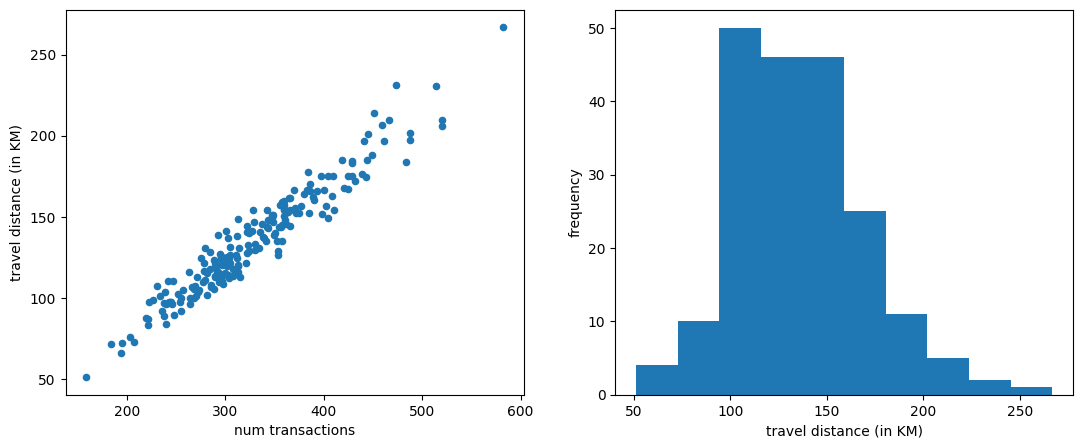

In [26]:
plot1_total_travel_distance(fake_transactions, scoring_base)

`NOTES`

1. As expected, the number of transactions is **positively correlated** with the total travel distance
2. The distribution of the total travel distance should mirror a **normal distibution** (refer to stay_proba).

Let's check the extreme scenarios. Sample subs with the lowest, highest, and the median `total_travel_distance`

In [27]:
metric = "total_travel_distance"
sample_traj_low, sample_traj_mid, sample_traj_high = fetch_sample_trajs(scoring_base, metric, date, window, fake_transactions, fake_cellsites)

In [28]:
def fetch_total_travel_distance(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    dts = traj.transaction_dt.tolist()
    hrs = traj.transaction_hr.tolist()
    cels = traj.cel_uid.tolist()
    hr_pairs = list(zip(hrs, hrs[1:]))
    travel_distances = list(map(lambda p: calc_haversine_distance(*p), od_pairs))
    dt_df = pd.DataFrame(list(zip(dts, dts[1:])), columns=["orig_dt", "dest_dt"])
    hr_df = pd.DataFrame(list(zip(hrs, hrs[1:])), columns=["orig_hr", "dest_hr"])
    cel_df = pd.DataFrame(list(zip(cels, cels[1:])), columns=["orig_cel", "dest_cel"])
    data = pd.concat([dt_df, hr_df, cel_df], axis=1)
    data["travel_distance"] = travel_distances
    return data.loc[data.travel_distance>0].reset_index(drop=True)

def plot_total_travel_distances(traj_low, traj_mid, traj_high):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    sample_low = fetch_total_travel_distance(traj_low)
    sample_mid = fetch_total_travel_distance(traj_mid)
    sample_high = fetch_total_travel_distance(traj_high)
    sample_low["orig_dt"] = pd.to_datetime(sample_low["orig_dt"])
    sample_mid["orig_dt"] = pd.to_datetime(sample_mid["orig_dt"])
    sample_high["orig_dt"] = pd.to_datetime(sample_high["orig_dt"])
    sample_low.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax1, color="red", kind="line")
    sample_mid.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax1, color="blue", kind="line")
    sample_high.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax1, color="green", kind="line")
    sample_low.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax2, color="red", kind="density")
    sample_mid.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax2, color="blue", kind="density")
    sample_high.groupby("orig_dt")["travel_distance"].sum().div(1_000).plot(ax=ax2, color="green", kind="density")
    ax1.set_ylabel("travel distance (in KM)")
    ax2.set_ylabel("density")
    ax1.set_xlabel("")
    ax2.set_xlabel("travel distance (in KM)")
    ax1.legend(["low", "mid", "high"], frameon=False)
    ax2.legend(["low", "mid", "high"], frameon=False)
    plt.tight_layout()
    plt.close();
    return fig

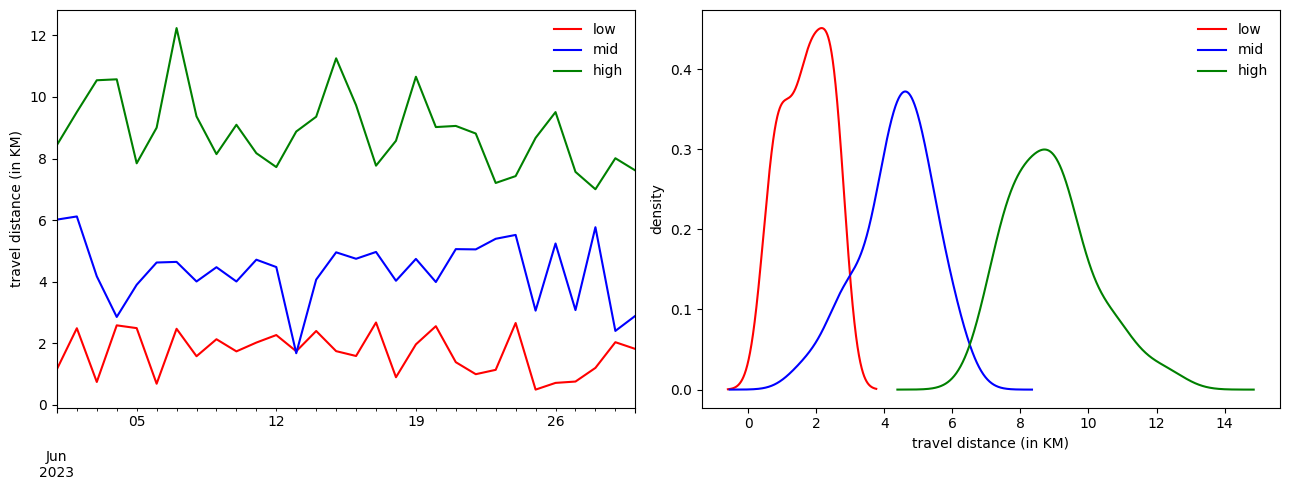

In [29]:
# this is a sample 
plot_total_travel_distances(sample_traj_low, sample_traj_mid, sample_traj_high)

`NOTE`

This contains only a few sample of the scoring base, you should not draw conclusions for the whole population here. We just wanted to check the extreme scenarios, how varied is the day-to-day movement of these subs. We also wanted to check how is the travel distance distributed in a single month for the three extreme scenarios.

## 2: `radius of_gyration`

In mobility analysis, this indicates the characteristic distance travelled by the agent (in our case, the mobile subscriber). This is computed using the given formula.

$ RoG = \sqrt{\frac{1}{n} \sum_{i=1}^{n} d(CoM, coord_i)^2} $  <br>

$ RoG $ is the Radius of Gyration <br>
$ d $ is the Haversine distance <br>

$ CoM = \left( \frac{1}{n} \sum_{i=1}^{n} lat_i, \frac{1}{n} \sum_{i=1}^{n} lng_i \right) $  <br>

$ CoM $ is the Center of Mass


### a. **CHECK** the `radius_of_gyration` of a subscriber.

In [30]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-61960,glo-sub-057,glo-cel-022,2023-06-01,2,POINT (121.0462595 14.5165155)
1,glo-txn-61961,glo-sub-057,glo-cel-018,2023-06-01,4,POINT (121.0448854 14.5140967)
2,glo-txn-61962,glo-sub-057,glo-cel-032,2023-06-01,5,POINT (121.0499415 14.5159856)
3,glo-txn-61963,glo-sub-057,glo-cel-022,2023-06-01,8,POINT (121.0462595 14.5165155)
4,glo-txn-61964,glo-sub-057,glo-cel-032,2023-06-01,10,POINT (121.0499415 14.5159856)


In [31]:
coords = traj.coords.tolist()

In [32]:
mean_lat = np.mean([shapely.wkt.loads(coord).y for coord in coords])
mean_lng = np.mean([shapely.wkt.loads(coord).x for coord in coords])
com = shapely.geometry.Point(mean_lng, mean_lat).wkt

In [33]:
print(mean_lat, mean_lng, com)

14.525537502459017 121.06894373606558 POINT (121.06894373606558 14.525537502459017)


In [34]:
# compute for the distances from center of mass to each of the individual points
pt_pairs = list(zip(coords, [com]*len(coords))) # points to center of mass
radius_of_gyration = np.sqrt(
    reduce(
        lambda a, b: a + b,
        list(map(lambda p: calc_haversine_distance(*p)**2, pt_pairs))
    ) / len(coords)
)

In [35]:
radius_of_gyration / 1_000

1.7257715740318065

### b. **APPLY** the `radius_of_gyration` to the scoring base.

In [36]:
def calc_radius_of_gyration(traj):
    
    coords = traj.coords.tolist()
    
    # compute for the center of mass
    mean_lat = np.mean([shapely.wkt.loads(coord).y for coord in coords])
    mean_lng = np.mean([shapely.wkt.loads(coord).x for coord in coords])
    com = shapely.geometry.Point(mean_lng, mean_lat).wkt
    
    # compute for the distances from CoM to individual points
    pt_pairs = list(zip(coords, [com]*len(coords)))
    radius_of_gyration = np.sqrt(
        reduce(
            lambda a, b: a + b,
            list(map(lambda p: calc_haversine_distance(*p)**2, pt_pairs))
        ) / len(coords)
    )
    return com, radius_of_gyration

In [37]:
radius_of_gyrations = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    radius_of_gyration = calc_radius_of_gyration(traj)[-1]
    radius_of_gyrations.append(radius_of_gyration)

scoring_base["radius_of_gyration"] = radius_of_gyrations

In [38]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance,radius_of_gyration
180,glo-sub-105,male,41,Joseph Jones,False,N,177658.951978,2810.052281
92,glo-sub-098,male,19,Mark Vaughn,False,Y,126589.048483,2114.051387
71,glo-sub-192,male,32,Richard Newton,True,Y,119538.830436,1530.685541
137,glo-sub-014,female,48,Laura Moody,False,N,150502.600987,1885.134654
129,glo-sub-048,female,51,Amanda Nunez,False,Y,146620.845733,1907.315216


### c. **VISUALIZE** the `radius of gyration` results.

In [39]:
metric = "radius_of_gyration"
sample_traj_low, sample_traj_mid, sample_traj_high = fetch_sample_trajs(scoring_base, metric, date, window, fake_transactions, fake_cellsites)

In [40]:
sample_traj_low.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-22148,glo-sub-129,glo-cel-095,2023-06-01,5,POINT (121.0802442 14.5467116)
1,glo-txn-22149,glo-sub-129,glo-cel-093,2023-06-01,7,POINT (121.0789244 14.5493345)
2,glo-txn-22150,glo-sub-129,glo-cel-096,2023-06-01,8,POINT (121.0804294 14.5420173)
3,glo-txn-22151,glo-sub-129,glo-cel-095,2023-06-01,13,POINT (121.0802442 14.5467116)
4,glo-txn-22152,glo-sub-129,glo-cel-087,2023-06-01,14,POINT (121.0751054 14.5445315)


In [53]:
def buffer_from_point(lat, lng, radius):
    wgs84_globe = pyproj.Proj(proj="latlong", ellps="WGS84")
    aeqd = pyproj.Proj(proj="aeqd", ellps="WGS84", datum="WGS84", lat_0=lat, lon_0=lng)
    project_coords = pyproj.transform(wgs84_globe, aeqd, lng, lat)
    aeqd_buffer = shapely.geometry.Point(project_coords).buffer(radius) 
    projected_pol = shapely.ops.transform(partial(pyproj.transform, aeqd, wgs84_globe), aeqd_buffer)
    return projected_pol

def plot_radius_of_gyrations(traj_low, traj_mid, traj_high):
    com_low, rog_low = calc_radius_of_gyration(traj_low)
    com_mid, rog_mid = calc_radius_of_gyration(traj_mid)
    com_high, rog_high = calc_radius_of_gyration(traj_high)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5), sharex=True, sharey=True)
    gpd.GeoSeries(shapely.wkt.loads(com_low)).plot(ax=ax1, marker="*", color="black", markersize=300, zorder=2)
    gpd.GeoSeries(buffer_from_point(lat=shapely.wkt.loads(com_low).y, lng=shapely.wkt.loads(com_low).x, radius=rog_low))\
        .plot(ax=ax1, color="white", edgecolor="black", zorder=3, alpha=0.2, linewidth=10)
    gpd.GeoSeries(shapely.wkt.loads(com_mid)).plot(ax=ax2, marker="*", color="black", markersize=300, zorder=2)
    gpd.GeoSeries(buffer_from_point(lat=shapely.wkt.loads(com_mid).y, lng=shapely.wkt.loads(com_mid).x, radius=rog_mid))\
        .plot(ax=ax2, color="white", edgecolor="black", zorder=3, alpha=0.2, linewidth=10)
    gpd.GeoSeries(shapely.wkt.loads(com_high)).plot(ax=ax3, marker="*", color="black", markersize=300, zorder=2)
    gpd.GeoSeries(buffer_from_point(lat=shapely.wkt.loads(com_high).y, lng=shapely.wkt.loads(com_high).x, radius=rog_high))\
        .plot(ax=ax3, color="white", edgecolor="black", zorder=3, alpha=0.2, linewidth=10)
    gpd.GeoSeries(traj_low["coords"].apply(shapely.wkt.loads)).plot(ax=ax1, color="red", markersize=60, zorder=1)
    gpd.GeoSeries(traj_mid["coords"].apply(shapely.wkt.loads)).plot(ax=ax2, color="blue", markersize=60, zorder=1)
    gpd.GeoSeries(traj_high["coords"].apply(shapely.wkt.loads)).plot(ax=ax3, color="green", markersize=60, zorder=1)
    ax1.ticklabel_format(useOffset=False)
    ax2.ticklabel_format(useOffset=False)
    ax3.ticklabel_format(useOffset=False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.tight_layout()
    plt.close();
    return fig

def plot_radius_of_gyration(traj):
    com, rog = calc_radius_of_gyration(traj)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    gpd.GeoSeries(shapely.wkt.loads(com)).plot(ax=ax, marker="*", color="black", markersize=300, zorder=2)
    gpd.GeoSeries(buffer_from_point(lat=shapely.wkt.loads(com).y, lng=shapely.wkt.loads(com).x, radius=rog))\
        .plot(ax=ax, color="white", edgecolor="black", zorder=3, alpha=0.2, linewidth=10)
    gpd.GeoSeries(traj["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="red", markersize=60, zorder=1)
    ax.ticklabel_format(useOffset=False)
    plt.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.close();
    return fig

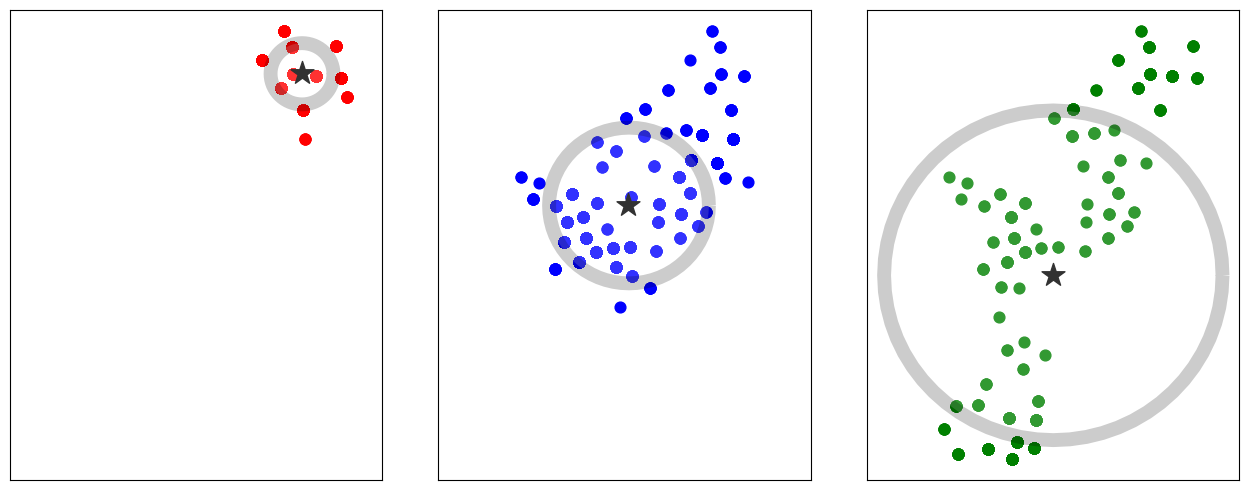

In [54]:
plot_radius_of_gyrations(sample_traj_low, sample_traj_mid, sample_traj_high)

`NOTE`

This contains only a handful sample of the scoring base, particularly the highest, lowest, and the median `radius_of_gyrations`. This simply illustrates (visually) the extremity of the range of the radius for each scenarios, to understand the concept of RoG better.

## 3: `activity_entropy`

Check activity entropy for a sample sub trajectory

In [34]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-58921,glo-sub-027,glo-cel-005,2023-06-01,6,POINT (121.0281256 14.5208775)
2,glo-txn-58922,glo-sub-027,glo-cel-006,2023-06-01,7,POINT (121.03083 14.5277572)
1,glo-txn-58923,glo-sub-027,glo-cel-005,2023-06-01,9,POINT (121.0281256 14.5208775)
3,glo-txn-58924,glo-sub-027,glo-cel-007,2023-06-01,10,POINT (121.0342338 14.5181996)
4,glo-txn-58925,glo-sub-027,glo-cel-009,2023-06-01,13,POINT (121.0347379 14.5119065)


In [35]:
loc_hrs = traj[["cel_uid", "transaction_hr"]].values.tolist()
od_loc_hrs = list(zip(loc_hrs, loc_hrs[1:]))

In [36]:
cels = list(set(traj.cel_uid.tolist()))

In [37]:
loc_hr_counter = dict(zip(cels, [0]*len(cels))) # THIS IS THE HASHMAP
for od_loc_hr in od_loc_hrs:
    orig = od_loc_hr[0]
    dest = od_loc_hr[1]
    cel = orig[0]
    if dest[1] > orig[1]:
        time_elapsed = dest[1] - orig[1]
    elif dest[1] < orig[1]:
        # next time elapsed jumps to another day
        time_elapsed = 24 - abs(dest[1] - orig[1])
    loc_hr_counter[cel] = loc_hr_counter[cel] + time_elapsed #  # I UPDATED THE HASHMAP

In [38]:
loc_hr_counter

{'glo-cel-074': 8,
 'glo-cel-012': 2,
 'glo-cel-088': 2,
 'glo-cel-089': 39,
 'glo-cel-087': 10,
 'glo-cel-039': 7,
 'glo-cel-070': 29,
 'glo-cel-097': 5,
 'glo-cel-008': 3,
 'glo-cel-090': 2,
 'glo-cel-082': 3,
 'glo-cel-080': 14,
 'glo-cel-086': 25,
 'glo-cel-103': 7,
 'glo-cel-006': 2,
 'glo-cel-043': 13,
 'glo-cel-083': 26,
 'glo-cel-071': 12,
 'glo-cel-093': 5,
 'glo-cel-011': 5,
 'glo-cel-078': 14,
 'glo-cel-091': 10,
 'glo-cel-084': 75,
 'glo-cel-094': 15,
 'glo-cel-079': 22,
 'glo-cel-010': 1,
 'glo-cel-049': 4,
 'glo-cel-014': 10,
 'glo-cel-007': 3,
 'glo-cel-036': 2,
 'glo-cel-064': 19,
 'glo-cel-092': 20,
 'glo-cel-077': 32,
 'glo-cel-018': 10,
 'glo-cel-085': 3,
 'glo-cel-032': 1,
 'glo-cel-057': 7,
 'glo-cel-066': 30,
 'glo-cel-095': 16,
 'glo-cel-005': 2,
 'glo-cel-076': 1,
 'glo-cel-046': 15,
 'glo-cel-009': 1,
 'glo-cel-101': 21,
 'glo-cel-051': 12,
 'glo-cel-073': 25,
 'glo-cel-056': 28,
 'glo-cel-040': 8,
 'glo-cel-013': 13,
 'glo-cel-096': 41,
 'glo-cel-061': 4,
 'gl

In [39]:
traj # sanity check

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-58921,glo-sub-027,glo-cel-005,2023-06-01,6,POINT (121.0281256 14.5208775)
2,glo-txn-58922,glo-sub-027,glo-cel-006,2023-06-01,7,POINT (121.03083 14.5277572)
1,glo-txn-58923,glo-sub-027,glo-cel-005,2023-06-01,9,POINT (121.0281256 14.5208775)
3,glo-txn-58924,glo-sub-027,glo-cel-007,2023-06-01,10,POINT (121.0342338 14.5181996)
4,glo-txn-58925,glo-sub-027,glo-cel-009,2023-06-01,13,POINT (121.0347379 14.5119065)
...,...,...,...,...,...,...
32,glo-txn-59195,glo-sub-027,glo-cel-039,2023-06-30,14,POINT (121.0536333 14.5133711)
275,glo-txn-59196,glo-sub-027,glo-cel-046,2023-06-30,16,POINT (121.0560984 14.5100246)
33,glo-txn-59197,glo-sub-027,glo-cel-039,2023-06-30,19,POINT (121.0536333 14.5133711)
276,glo-txn-59198,glo-sub-027,glo-cel-046,2023-06-30,20,POINT (121.0560984 14.5100246)


In [40]:
proba_per_site = [hr_spent/sum(loc_hr_counter.values()) for hr_spent in loc_hr_counter.values()]

In [41]:
np.sum(proba_per_site)

1.0000000000000002

In [42]:
activity_entropy = reduce(lambda a, b: a + b, map(lambda p: p*np.log10(1/p), proba_per_site))
print(activity_entropy)

# TODO: add logbase2
# try float dtype

1.5510208886967467


Apply `calc_activity_entropy` to the scoring base

In [43]:
def calc_activity_entropy(traj):
    
    try:
    
        loc_hrs = traj[["cel_uid", "transaction_hr"]].values.tolist()
        od_loc_hrs = list(zip(loc_hrs, loc_hrs[1:]))    
        cels = list(set(traj.cel_uid.tolist()))

        loc_hr_counter = dict(zip(cels, [0]*len(cels)))
        for od_loc_hr in od_loc_hrs:
            orig = od_loc_hr[0]
            dest = od_loc_hr[1]
            cel = orig[0]
            if dest[1] > orig[1]:
                time_elapsed = dest[1] - orig[1]
            elif dest[1] < orig[1]:
                # next time elapsed jumps to another day
                time_elapsed = 24 - abs(dest[1] - orig[1])
            loc_hr_counter[cel] = loc_hr_counter[cel] + time_elapsed

        # time spent on a single site vs time spent on all sites
        proba_per_site = [hr_spent/sum(loc_hr_counter.values()) for hr_spent in loc_hr_counter.values()]

        # sum(p * log(1/p)) where p is the proba for a single site
        activity_entropy = reduce(lambda a, b: a + b, map(lambda p: p*np.log10(1/p), proba_per_site))
    
        return activity_entropy
    
    except:
        
        return None

In [44]:
activity_entropys = []
for sub in scoring_base.sub_uid.tolist():
    traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)
    activity_entropy = calc_activity_entropy(traj)
    activity_entropys.append(activity_entropy)

scoring_base["activity_entropy"] = activity_entropys

In [45]:
scoring_base.sample(5)

,sub_uid,gender,age,name,chi_indicator,ewallet_user_indicator,total_travel_distance,radius_of_gyration,activity_entropy
163,glo-sub-164,female,22,Gloria Trujillo,True,Y,115182.369226,1403.441567,1.510481
113,glo-sub-114,male,47,Derek Davis,True,Y,167734.591832,1493.636042,1.558330
128,glo-sub-129,female,51,Kimberly Reed,False,N,110645.495795,578.135988,0.949096
14,glo-sub-015,male,50,Michael Hamilton,True,N,121623.648025,1706.857045,1.541325
18,glo-sub-019,female,53,Rachael Meyers,False,Y,154121.590363,875.080916,1.180302


## 4. Visualization

if stay_proba is low, likely to have:

- LOWER total_travel_distance <br>
- LOWER radius_of_gyration <br>
- LOWER activity_entropy

In [29]:
def plot_routes(traj_low, traj_mid, traj_high):
    coords_low = traj_low.coords.tolist()
    coords_mid = traj_mid.coords.tolist()
    coords_high = traj_high.coords.tolist()
    od_pairs_low = list(zip(coords_low, coords_low[1:]))
    od_pairs_mid = list(zip(coords_mid, coords_mid[1:]))
    od_pairs_high = list(zip(coords_high, coords_high[1:]))
    routes_low, routes_mid, routes_high = [], [], []
    for od_pair in od_pairs_low:
        routes_low.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    for od_pair in od_pairs_mid:
        routes_mid.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    for od_pair in od_pairs_high:
        routes_high.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 7), sharex=True, sharey=True)
    gpd.GeoSeries(traj_low["coords"].apply(shapely.wkt.loads)).plot(ax=ax1, color="red", markersize=60, zorder=2);
    gpd.GeoSeries(traj_mid["coords"].apply(shapely.wkt.loads)).plot(ax=ax2, color="blue", markersize=60, zorder=2);
    gpd.GeoSeries(traj_high["coords"].apply(shapely.wkt.loads)).plot(ax=ax3, color="green", markersize=60, zorder=2);
    gpd.GeoSeries(routes_low).plot(ax=ax1, color="grey", linewidth=3, zorder=1, alpha=0.6)
    gpd.GeoSeries(routes_mid).plot(ax=ax2, color="grey", linewidth=3, zorder=1, alpha=0.6)
    gpd.GeoSeries(routes_high).plot(ax=ax3, color="grey", linewidth=3, zorder=1, alpha=0.6)
    ax1.ticklabel_format(useOffset=False)
    ax2.ticklabel_format(useOffset=False)
    ax3.ticklabel_format(useOffset=False)
    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax1.legend(["low"], frameon=False, loc="lower center")
    ax2.legend(["mid"], frameon=False, loc="lower center")
    ax3.legend(["high"], frameon=False, loc="lower center")
    plt.tight_layout()
    plt.close()
    return fig

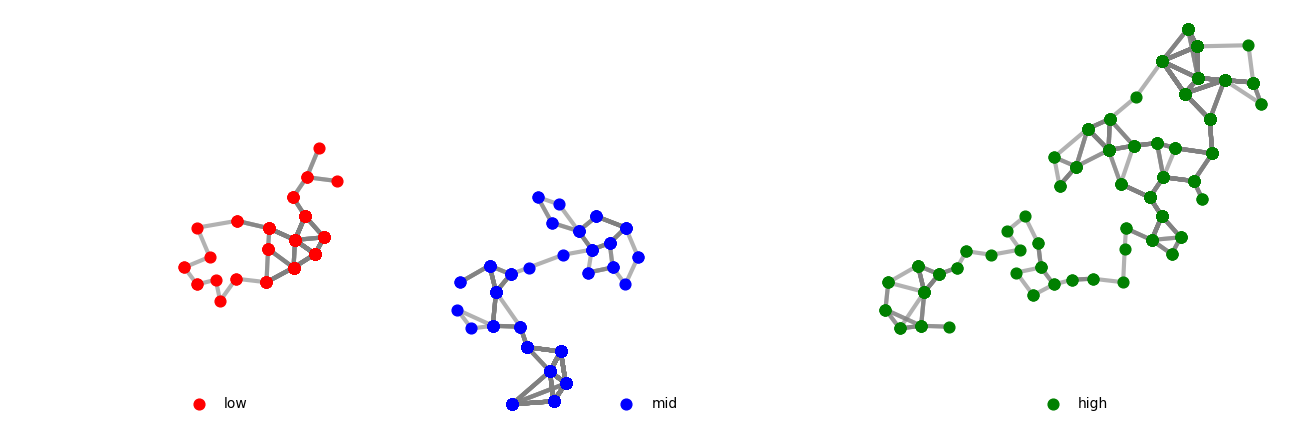

In [30]:
plot_routes(sample_traj_low, sample_traj_mid, sample_traj_high)

`NOTE`: Total travel distance alone, cannot be used to approximate mobilty.

In [26]:
scoring_base.sort_values(by="total_travel_distance", ascending=True, inplace=True)
scoring_base.reset_index(drop=True, inplace=True)

In [27]:
sample_sub_low = scoring_base.loc[0, "sub_uid"]
sample_sub_mid = scoring_base.loc[len(scoring_base)//2, "sub_uid"]
sample_sub_high = scoring_base.loc[len(scoring_base)-1, "sub_uid"]

In [28]:
sample_traj_low = get_sub_traj(sample_sub_low, date, window, fake_transactions, fake_cellsites)
sample_traj_mid = get_sub_traj(sample_sub_mid, date, window, fake_transactions, fake_cellsites)
sample_traj_high = get_sub_traj(sample_sub_high, date, window, fake_transactions, fake_cellsites)

In [83]:
def visualize_route(traj):
    coords = traj.coords.tolist()
    od_pairs = list(zip(coords, coords[1:]))
    routes = []
    for od_pair in od_pairs:
        routes.append(
            shapely.geometry.LineString(
                map(shapely.wkt.loads, od_pair)
            )
        )
    fig, ax = plt.subplots(1, figsize=(7, 5))
    gpd.GeoSeries(traj["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="blue", markersize=60, zorder=2);
    gpd.GeoSeries(traj.head(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="green", markersize=120, zorder=3);
    gpd.GeoSeries(traj.tail(1)["coords"].apply(shapely.wkt.loads)).plot(ax=ax, color="red", markersize=120, zorder=3);
    gpd.GeoSeries(routes).plot(ax=ax, color="grey", linewidth=3, zorder=1, alpha=0.6)
    ax.ticklabel_format(useOffset=False)
    ax.legend(["_", "orig", "dest"])
    plt.tight_layout()
    plt.axis("off")
    plt.close()
    return fig

this sub travelled 51.18 KM in a month, LIKELY TO HAVE LOW MOBILITY


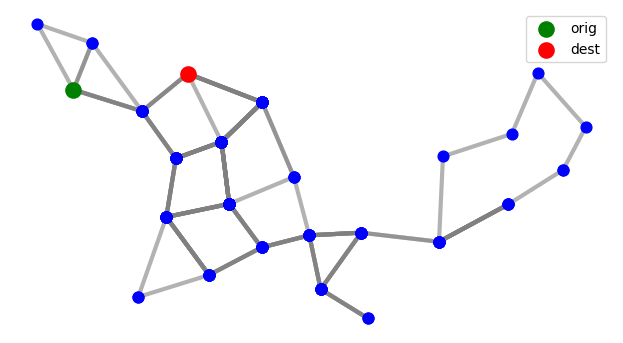

In [84]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_low, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE LOW MOBILITY")
display(visualize_route(sample_traj_low))

this sub travelled 130.69 KM in a month, LIKELY TO HAVE MID MOBILITY


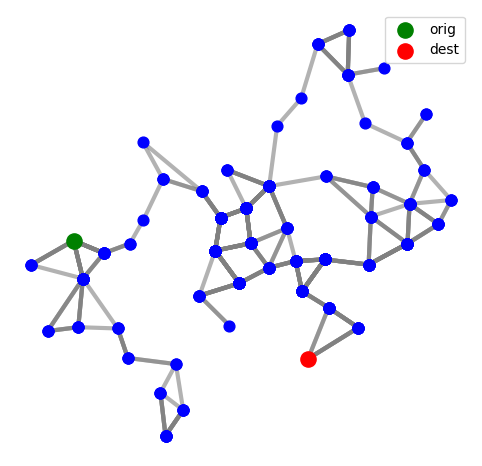

In [85]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_mid, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE MID MOBILITY")
display(visualize_route(sample_traj_mid))

this sub travelled 266.82 KM in a month, LIKELY TO HAVE HIGH MOBILITY


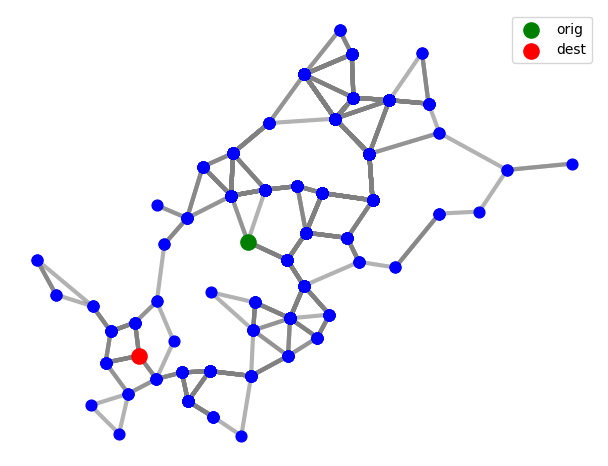

In [86]:
travel_distance_in_km = round(scoring_base.loc[scoring_base.sub_uid==sample_sub_high, "total_travel_distance"].item() / 1_000, 2)
print(f"this sub travelled {travel_distance_in_km} KM in a {window}, LIKELY TO HAVE HIGH MOBILITY")
display(visualize_route(sample_traj_high))

TODO:
1. Make your own Mobility Index: HIGH-MID-LOW

## RESULTS QA

In [46]:
scoring_base.total_travel_distance.describe().iloc[1:]

mean    135365.978688
std      34060.304293
min      51182.047777
25%     111875.270825
50%     130679.843486
75%     154596.447748
max     266816.677803
Name: total_travel_distance, dtype: float64

In [47]:
scoring_base.radius_of_gyration.describe().iloc[1:]

mean    1488.527682
std      454.251797
min      578.135988
25%     1192.525488
50%     1466.560640
75%     1760.898864
max     3112.181536
Name: radius_of_gyration, dtype: float64

In [48]:
scoring_base.activity_entropy.describe().iloc[1:]

mean    1.439375
std     0.150639
min     0.919816
25%     1.358496
50%     1.467371
75%     1.541902
max     1.741984
Name: activity_entropy, dtype: float64

In [49]:
sub = fake_subscribers.sample(1).sub_uid.item()
traj = get_sub_traj(sub, date, window, fake_transactions, fake_cellsites)

In [50]:
traj.head()

,txn_uid,sub_uid,cel_uid,transaction_dt,transaction_hr,coords
0,glo-txn-52770,glo-sub-075,glo-cel-018,2023-06-01,3,POINT (121.0448854 14.5140967)
1,glo-txn-52771,glo-sub-075,glo-cel-032,2023-06-01,4,POINT (121.0499415 14.5159856)
2,glo-txn-52772,glo-sub-075,glo-cel-022,2023-06-01,5,POINT (121.0462595 14.5165155)
3,glo-txn-52773,glo-sub-075,glo-cel-027,2023-06-01,7,POINT (121.0482758 14.5207167)
8,glo-txn-52774,glo-sub-075,glo-cel-036,2023-06-01,8,POINT (121.052231 14.519476)


In [51]:
calc_activity_entropy(traj)

1.5298917317491276

In [52]:
calc_radius_of_gyration(traj)

1678.0288201073324

In [53]:
calc_total_travel_distance(traj)

184442.6669373246

## PENDING ITEMS

[X] Redo the fake data simulation, make stay proba variable instead of fixed <br>
[] Add visuals on total travel distance, radius of gyration, activity entropy <br>
[] Finish lecture part 1, grammar of spatial data science

## ARCHIVE

In [14]:
def get_route_fig(r):
    fig, ax = plt.subplots(1, 1)
    gpd.GeoSeries(r).plot(ax=ax, linewidth=5, zorder=1)
    orig = shapely.geometry.Point([r.xy[0][0], r.xy[1][0]])
    dest = shapely.geometry.Point([r.xy[0][-1], r.xy[1][-1]])
    gpd.GeoSeries(orig).plot(ax=ax, color="red", markersize=250, zorder=2, alpha=0.8)
    gpd.GeoSeries(dest).plot(ax=ax, color="green", markersize=250, zorder=2, alpha=0.8)
    plt.axis("off")
    ax.ticklabel_format(useOffset=False)
    plt.close()
    return fig

import os
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
import shutil

In [15]:
# day in a life of a sub
d = fake_transactions.copy()
sample_sub = d.sample(1).sub_id.item()
d = d.loc[d.sub_id==sample_sub]
days = d.transaction_dt.unique().tolist()
route_figs = []
for sample_day in days:
    sites = fake_transactions\
        .loc[fake_transactions.sub_id==sample_sub]\
        .loc[fake_transactions.transaction_dt==sample_day]\
        .cel_id.tolist()
    points = list(map(lambda z: convert_cel_to_point(z, fake_cellsites), sites))
    r = shapely.geometry.LineString(points)
    route_figs.append(get_route_fig(r))
os.mkdir("../sample/")
for idx, fig in enumerate(route_figs):
    fname = "../sample/{}_tmp.jpg".format(idx+1)
    fig.savefig(fname)
imgs = load_images("../sample")
plot_images(imgs)
shutil.rmtree("../sample")

AttributeError: 'DataFrame' object has no attribute 'uid'